In [35]:
from sympy import symbols, init_printing
import sympy
import sympy.physics.mechanics as me
from pydy.system import System
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.integrate import ode, odeint
from sympy.utilities.lambdify import lambdastr
from scipy.optimize import fsolve
import numpy as np
%matplotlib inline
# init_printing(False)
init_printing(True)
import InputShaping as shaping
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [36]:
# Create the symbols
x, z, theta = me.dynamicsymbols('x z theta')
x_dot, z_dot, theta_dot = me.dynamicsymbols('x_dot z_dot theta_dot')
H, m, g, k, t = sympy.symbols('H m g k_{cable} t')
I, c, r, p, kr, cr, D = sympy.symbols('I c r p k_{rod} c_{rod} D')
L1, L2 = me.dynamicsymbols('L1 L2')
# L1, L2 = sympy.symbols('L1 L2')
k_C, e_offset = sympy.symbols('k_C e_offset')

# Create the frames Z+ points down, and Y+ is out of the screen
A = me.ReferenceFrame('A')
B = A.orientnew('B', 'Axis', [theta, A.y])

# Create the frames angular velocity
B.set_ang_vel(A, theta_dot * A.y)

In [47]:
def s_curve(CurrTime, Begin, Amp, RiseTime, StartTime):
    """
    This was copied from Dr. Vaughan's Input shaping Library
    I edited it to allow for a beginning value.

    Function to generate an s-curve command

    Arguments:
      CurrTime : The current timestep or an array of times
      Amp : The magnitude of the s-curve (or final setpoint)
      RiseTime : The rise time of the curve
      StartTime : The time that the command should StartTime
      Begin : The beginnning value

    Returns :
      The command at the current timestep or an array representing the command
      over the times given (if CurrTime was an array)
    """

    Amp = Amp - Begin
    scurve = (2.0 * ((CurrTime - StartTime)/RiseTime)**2 *
    (CurrTime-StartTime >= 0) * (CurrTime-StartTime < RiseTime/2)
    +(-2.0 * ((CurrTime - StartTime)/RiseTime)**2 + 4.0 * ((CurrTime -
    StartTime)/RiseTime) - 1.0) * (CurrTime-StartTime >= RiseTime/2) *
    (CurrTime-StartTime < RiseTime) + 1.0 * (CurrTime-StartTime >= RiseTime))

    return (Amp * scurve) + Begin

In [37]:
X_begin = 5.32
Y_begin = 7.5
# 7.84210526

# Ending Point
X_end = 10
Y_end = 7.5

# Time to get to Point
# To keep the velocity the same across the workspace
Risetime = np.sqrt((X_begin-10)**2 + (Y_begin - 7.5)**2)*(0.5)

# Time to start Moving
time_begin = 1.0

# Mass
mass = 10.0

# K of Cables
cable_K = 100.0

# C of Cables
cable_C = 10.0

# K of Rod
rod_K = 1.0

# C of Rod
rod_C = 1.0

# Length of Rod
rod_length = 3.0

# Time to plot response
endtime = 20.0

In [61]:
# Create the origin points
A1 = me.Point('A1')
A2 = me.Point('A2')

# Set the origin points positions
A1.set_pos(A1, 0)
A2.set_pos(A1, H * A.x)

# Create the attachment point
P = me.Point('P')

# Set position
P.set_pos(A1, x*A.x + z*A.z)

# Create the rod center point
G = me.Point('G')
G.set_pos(P, (D/2)*B.z)
bottom = me.Point('bottom')
bottom.set_pos(P, D * B.z)

s1 = P.pos_from(A1)
s2 = P.pos_from(A2)

# Calculating the Geometric lengths from the top corners of the plate
Length1 = s1.magnitude()
Length2 = s2.magnitude()

# Creating the unit vectors pointing from the origins to the top plate points
s1_vector = s1.normalize()
s2_vector = s2.normalize()

# Calculate the distance from the rod center to datum
rod_center_distance = A1.pos_from(G) & A.z

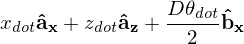

In [39]:
A1.set_vel(A, 0)
A2.set_vel(A, 0)

# Set velocity of COG
P.set_vel(A, x_dot * A.x + z_dot * A.z)
P.set_vel(B, 0)

G.set_vel(B, 0)
G.v2pt_theory(P, A, B)

In [63]:
bottom.pos_from(A1).express(A)

In [40]:
# Set up the kinematic differential equations
kde = [x_dot - x.diff(t),
       z_dot - z.diff(t),
       theta_dot - theta.diff(t)]

I_rod = me.inertia(A, 0, I, 0)
inertia_rod = (I_rod, G)
Rod = me.RigidBody('Rod', G, B, m, inertia_rod)

In [41]:
K1 = lambda LamLenK1: k * (LamLenK1 >= L1)
K2 = lambda LamLenK2: k * (LamLenK2 >= L2)
C1 = lambda LamLenC1: c * (LamLenC1 >= L1)
C2 = lambda LamLenC2: c * (LamLenC2 >= L2)

In [55]:
# Creating the forces acting on the body
grav_force_rod = (G, m * g * A.z)

spring_force_1 = (P, s1_vector * K1(Length1) * (L1 - Length1))
spring_force_2 = (P, s2_vector * K2(Length2) * (L2 - Length2))

damping_1 = (-C1(Length1) * P.vel(A) & s1_vector) * s1_vector
damping_2 = (-C2(Length2) * P.vel(A) & s2_vector) * s2_vector

# spring_force_1 = (P, s1_vector * k * (L1 - Length1))
# spring_force_2 = (P, s2_vector * k * (L2 - Length2))

# damping_1 = (-c * P.vel(A) & s1_vector) * s1_vector
# damping_2 = (-c * P.vel(A) & s2_vector) * s2_vector

damp_1 = (P, damping_1)
damp_2 = (P, damping_2)

B_frame_damp = (B, -1 * theta_dot * B.y)
B_frame_spring = (B, -10 * theta * B.y)

loads = [grav_force_rod,
         spring_force_1,
         spring_force_2,
         B_frame_damp,
         B_frame_spring,
         damp_1,
         damp_2]

In [56]:
# Setting up the coordinates, speeds, and creating KanesMethod
coordinates = [x, z, theta]
speeds = [x_dot, z_dot, theta_dot]
kane = me.KanesMethod(A, coordinates, speeds, kde)

# Creating Fr and Fr_star
fr, frstar = kane.kanes_equations(loads, [Rod])

# Creating the PyDy System
sys = System(kane)

In [57]:
# kdd = kane.kindiffdict()
# mm = kane.mass_matrix_full
# fo = kane.forcing_full

# # The final first order form is then solved for as
# # [q', u']^T = M^-1 * F.
# qudots_km = mm.inv() * fo
# qudots_km = qudots_km.subs(kdd)
# # qudots_km.simplify()
# # mprint(qudots_km)
# init_printing(True)
# print(sympy.latex(qudots_km[6].subs({theta:'theta', x:'x',z:'z',theta_dot:'theta_dot',x_dot:'x_dot',z_dot:'z_dot'})))

In [58]:
plate_inertia = (3**2 + 4**2) * (1/12.0)
workspace_width = 20
rod_length = 3
rod_inertia = (1 * (rod_length/2)**2) * (1/12)

In [59]:
# Assigning all the constants
runtime = 20
sys.constants = {m: 1,
                 g: 9.81,
                 H: workspace_width,
                 k : 100,
                 c : 10,
                 D: rod_length,
                 I: rod_inertia,
                 L1: 10,
                 L2: 10
                }
sys.initial_conditions = {x:4,
                          z:2,
                          theta:0.0}
# sys.specifieds = {L1: lambda q1, t:shaping.shaped_input(s_curve, t, Shaper, 
#                                     Length1_values[index], 
#                                     Length1_values[index_end], 3, 1),
#                   L2: lambda q2, t:shaping.shaped_input(s_curve, t, Shaper,
#                                     Length2_values[index],
#                                     Length2_values[index_end], 3, 1)}
sys.times = np.linspace(0.0, runtime, runtime * 30)
sys.generate_ode_function(generator='cython')
resp = sys.integrate()
# shaped_resp = sys.integrate()

In [ ]:
# # Assigning all the constants
# runtime = 20
# sys.constants = {m: mass,
#                  g: 9.81,
#                  H: 20,
#                  k : 100,
#                  c : 10,
#                  D: 3,
#                  I: 7.5
# #                  L1: 8.31242885,
# #                  L2: 15.91135799
#                 }
# sys.initial_conditions = {x:5.32,
#                           z:7.5,
#                           theta:0.0}
# sys.specifieds = {
# #                   L1: lambda q1, t:shaping.shaped_input(s_curve, t, Shaper, 
# #                                     Length1_values[index], 
# #                                     Length1_values[index_end], 3, 1),
# #                   L2: lambda q2, t:shaping.shaped_input(s_curve, t, Shaper,
# #                                     Length2_values[index],
# #                                     Length2_values[index_end], 3, 1)}

#                   L1: lambda q1, t:s_curve(t, 
#                                     8.31242885, 
#                                     11.6825, Risetime, 1),
#                   L2: lambda q2, t:s_curve(t,
#                                     15.91135799,
#                                     11.6825, Risetime, 1)
#     }
# sys.times = np.linspace(0.0, runtime, runtime * 30)
# sys.generate_ode_function(generator='cython')
# resp = sys.integrate()
# # shaped_resp = sys.integrate()

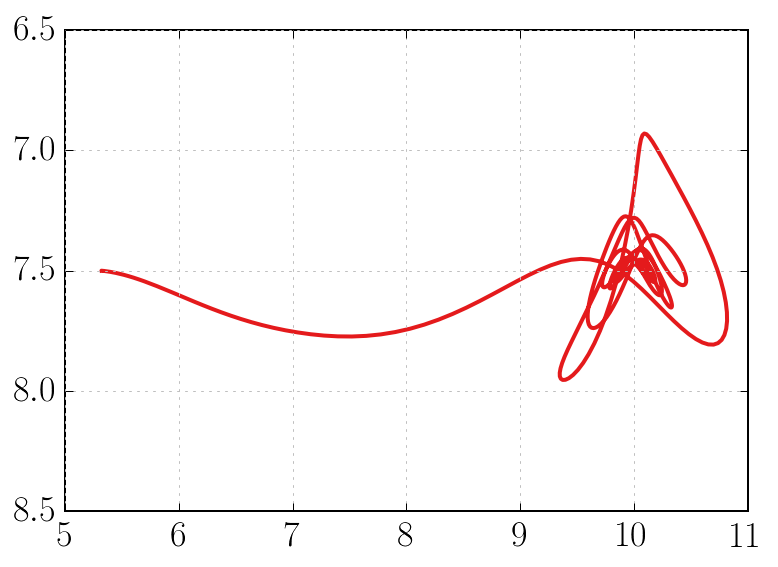

In [60]:
plt.plot(resp[:,0],resp[:,1])
plt.ylim(8.5,6.5);
plt.xlim(5,11);
# plt.gca().invert_yaxis()

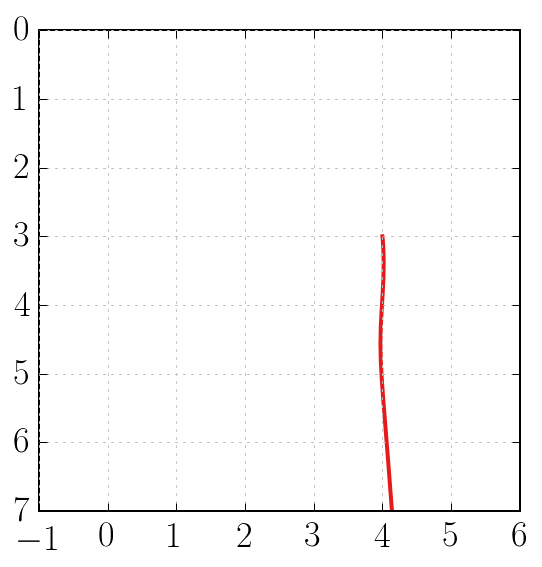

In [42]:
plt.plot(rod_length*np.sin(shaped_resp[:,2])/2 + shaped_resp[:,0], 
         rod_length*np.cos(shaped_resp[:,2])/2 + shaped_resp[:,1], label='Incompressible')
plt.ylim(7,0);
plt.xlim(-1,6);
plt.axes().set_aspect('equal')
# plt.axis('scaled')

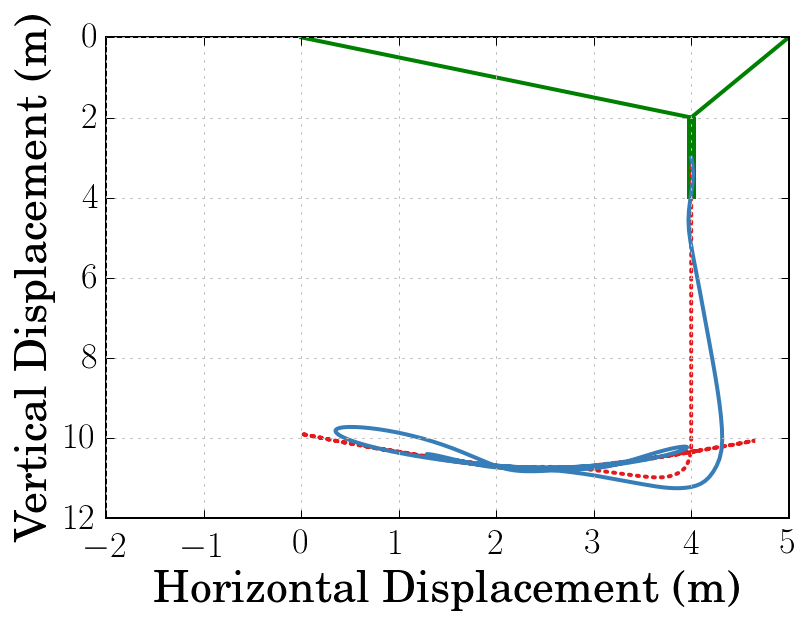

In [52]:
# plt.plot(resp[:,0], resp[:,1])
fig,ax = plt.subplots(1)
plt.plot(rod_length*np.sin(resp[:,2])/2 + resp[:,0], 
         rod_length*np.cos(resp[:,2])/2 + resp[:,1], linestyle=':', label='Compressible')
plt.plot(rod_length*np.sin(shaped_resp[:,2])/2 + shaped_resp[:,0], 
         rod_length*np.cos(shaped_resp[:,2])/2 + shaped_resp[:,1], label='Incompressible')
plt.plot([0,4],[0,2], color='g',label='Cables')
plt.plot([5,4],[0,2], color='g')

# plt.plot([0,2.5],[0,9.682458], color='g')
# plt.plot([5,2.5],[0,9.682458], color='g')
plt.gca().invert_yaxis()
import matplotlib.patches as patches
rect = patches.Rectangle((3.97,2),0.07,2,linewidth=1,edgecolor='g',facecolor='g')
# Add the patch to the Axes
ax.add_patch(rect)
plt.xlim(-2,5);
# plt.legend(fontsize='x-large', loc=(0.019,0.5))
plt.xlabel('Horizontal Displacement (m)')
plt.ylabel('Vertical Displacement (m)')
plt.ylim(12,0);
# plt.axes().set_aspect('equal')
# plt.savefig('Boolean_graph.pdf')

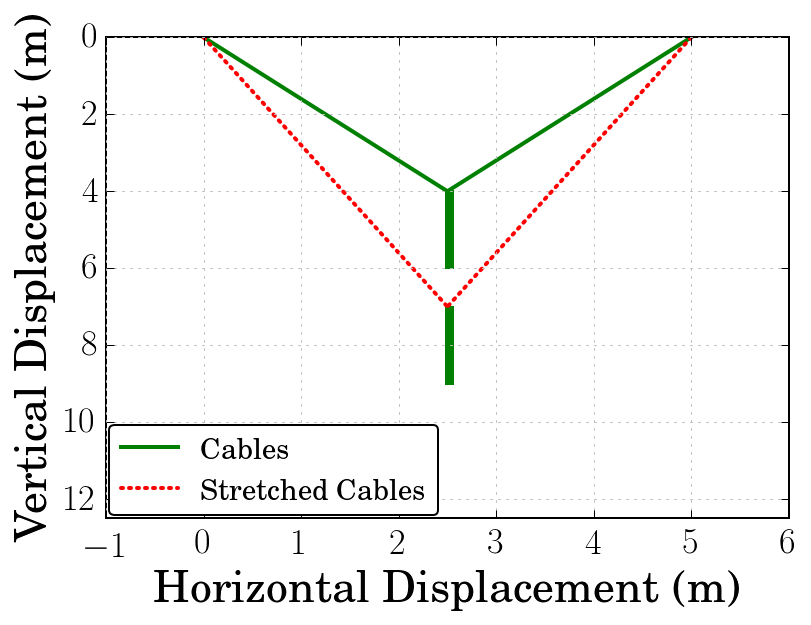

In [63]:
# plt.plot(resp[:,0], resp[:,1])
fig,ax = plt.subplots(1)
# plt.plot(rod_length*np.sin(resp[:,2])/2 + resp[:,0], 
#          rod_length*np.cos(resp[:,2])/2 + resp[:,1], linestyle=':', label='Compressible')
# plt.plot(rod_length*np.sin(shaped_resp[:,2])/2 + shaped_resp[:,0], 
#          rod_length*np.cos(shaped_resp[:,2])/2 + shaped_resp[:,1], label='Incompressible')
plt.plot([0,2.5],[0,4], color='g',label='Cables')
plt.plot([5,2.5],[0,4], color='g')

plt.plot([0,2.5],[0,7], color='r', linestyle=":",label='Stretched Cables')
plt.plot([5,2.5],[0,7], color='r', linestyle=":")

# plt.plot([0,2.5],[0,9.682458], color='g')
# plt.plot([5,2.5],[0,9.682458], color='g')
plt.gca().invert_yaxis()
import matplotlib.patches as patches
rect = patches.Rectangle((2.49,4),0.07,2,linewidth=1,edgecolor='g',facecolor='g')
rect2 = patches.Rectangle((2.49,7),0.07,2,linewidth=1,edgecolor='g',facecolor='g')
# Add the patch to the Axes
ax.add_patch(rect)
ax.add_patch(rect2)
plt.xlim(-1,6);
plt.legend(fontsize='x-large', loc='lower left')
plt.xlabel('Horizontal Displacement (m)')
plt.ylabel('Vertical Displacement (m)')
plt.ylim(12.5,0);
plt.savefig('Stretched.pdf')

In [15]:
def Lengths(x,y):
    k=1000
    h=2.635
    m=0.1425
    Fy = np.array([[k*y/np.sqrt(x**2 + y**2), k*y/np.sqrt(y**2 + (h - x)**2)],
                   [k*x/np.sqrt(x**2 + y**2), -h*k/np.sqrt(y**2 + (h - x)**2
                    )+k*x/np.sqrt(y**2 + (h - x)**2)]])
    a = np.array([2*k*y - 9.81*m,-h*k + 2*k*x])
    x = np.linalg.solve(Fy,a)
    return x

In [33]:
Lengths(10,7.5)

array([ 11.6825,  11.6825])

In [80]:
# Linearizing
op_point = {x:2.5,
            z:5,
            theta:0,
            x_dot:0,
            z_dot:0,
            theta_dot:0}

constants = {m: 0.1425,
             g: 9.81,
             H: 2.635,
             k : 1000,
             c : 10,
             D: 0.32,
             I: (0.1425 * 0.32**2) * (1/12),
             L1: 5.59008987,
             L2: 5.00049538
                }

In [81]:
linearizer = kane.to_linearizer()
Maz, A, B = linearizer.linearize()
M_op = me.msubs(Maz, op_point)
A_op = me.msubs(A, op_point)
B_op = me.msubs(B, op_point)

In [82]:
perm_mat = linearizer.perm_mat
A_lin = perm_mat.T * M_op.LUsolve(A_op)
B_lin = perm_mat.T * M_op.LUsolve(B_op)

A_lin_constants = me.msubs(A_lin, constants)
B_lin_constants = me.msubs(B_lin, constants)
A_sol = A_lin_constants.subs(op_point).doit()
B_sol = B_lin_constants.subs(op_point).doit()

A_np = np.array(np.array(A_sol), np.float)
B_np = np.array(np.array(B_sol), np.float)

eigenvals, eigenvects = np.linalg.eig(A_np)
eigen = eigenvals[0:5:2]
eigen_abs = np.abs(eigen)
damp = np.abs(np.real(eigen)/eigen_abs)

In [83]:
eigen_abs

array([ 4153.66362639,   114.66272552,    28.72360755])

In [84]:
eigen_abs

array([ 4153.66362639,   114.66272552,    28.72360755])

Processing frame 0
Processing frame 30
Processing frame 60
Processing frame 90
Processing frame 120
Processing frame 150
Processing frame 180
Processing frame 210
Processing frame 240
Processing frame 270


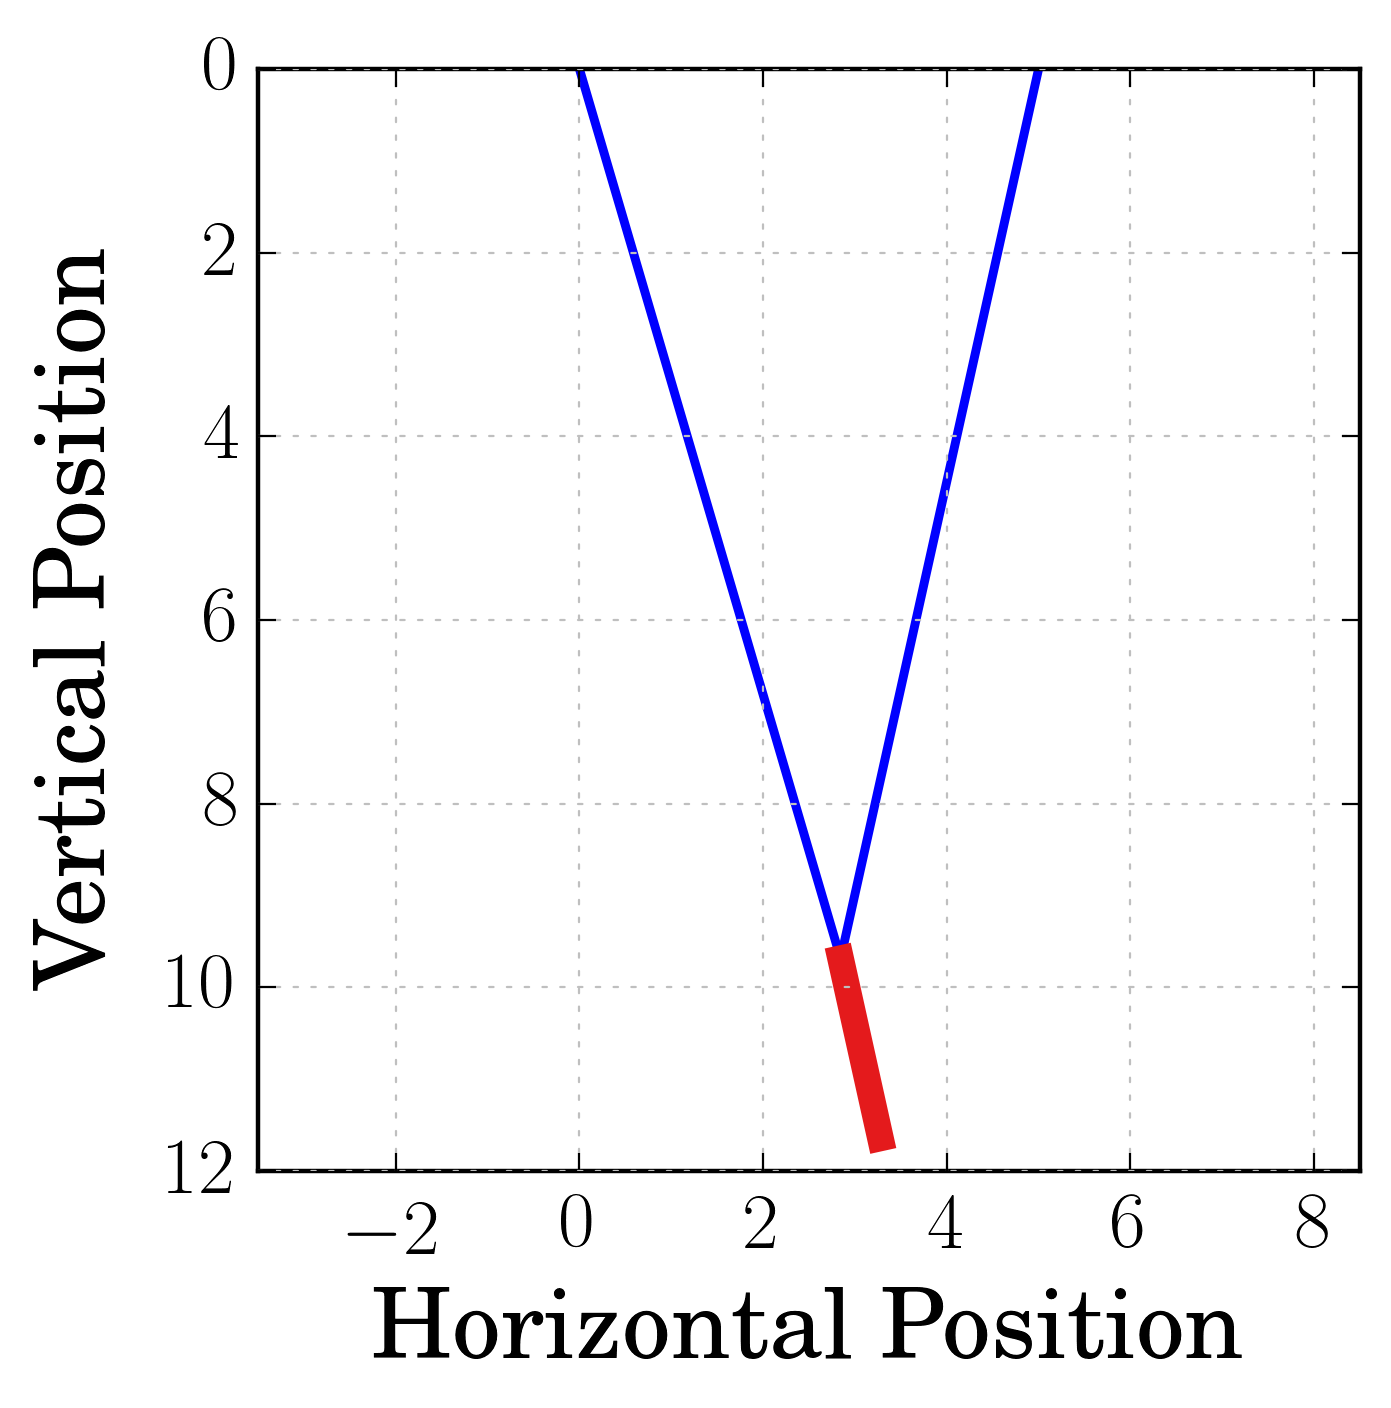

In [36]:
x_un = resp[:,0]
y_un = resp[:,1]

xp_un = resp[:,0] + rod_length/2 * np.sin(resp[:,2])
yp_un = resp[:,1] + rod_length/2 * np.cos(resp[:,2])

xend_un = resp[:,0] + rod_length * np.sin(resp[:,2])
yend_un = resp[:,1] + rod_length * np.cos(resp[:,2])

# plt.plot(x_un, y_un)
# plt.plot(xp_un, yp_un, label='Unshaped')
# plt.plot(xend_un, yend_un, label='Unshaped')

# x_s = response2[:,0]
# y_s = response2[:,1]

# xp_s = response2[:,0] + rod_length/2 * np.sin(response2[:,2])
# yp_s = response2[:,1] + rod_length/2 * np.cos(response2[:,2])

# xend_s = response2[:,0] + rod_length * np.sin(response2[:,2])
# yend_s = response2[:,1] + rod_length * np.cos(response2[:,2])

# plt.plot(x_s, y_s)
# plt.plot(xp_s, yp_s, label='Shaped')
# plt.plot(xend_s, yend_s, label='Shaped')

# plt.legend()
# plt.title('Front View Motion')
# # plt.ylim(25,0)
# plt.ylim(25,0)
# # plt.xlim(0,20)
# plt.xlim(0,20)
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.show()

# plt.figure(4)
# plt.plot(sim_time, s_curve(sim_time, 15.62, 20.61, 9.0, 3.0))
# plt.plot(sim_time, shaping.shaped_input(s_curve, sim_time, Shaper, 15.62,20.61,9.0,3.0))
# plt.show()

# Animation
import matplotlib.animation as animation

# Change some plot properties to make the video work and look better
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 160
mpl.rcParams['savefig.bbox'] = 'standard'
fig = plt.figure(figsize=(8,4.5))

leftcable, = plt.plot([],[], linewidth=2, linestyle = '-', label='leftcable', color='b')
rightcable, = plt.plot([],[], linewidth=2, linestyle = '-', label='rightcable', color='b')
barLine, = plt.plot([],[], linewidth=6, linestyle = '-', label='Bar')

plt.ylim(12,0);
plt.xlim(-3.5,8.5);
plt.xlabel('Horizontal Position', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Vertical Position', fontsize=22, weight='bold', labelpad=10)
plt.axes().set_aspect('equal')
plt.tight_layout()

def init():
    """ Initialize the lines in the plot """
    leftcable.set_data([], [])
    rightcable.set_data([], [])
    barLine.set_data([],[])

    return barLine, leftcable, rightcable,

def animate_un(i):
    """ Update the plot for frame i """
    if not (i % 30): # print notice every 30th frame
        print('Processing frame {}'.format(i))

    rightcable.set_data([0, x_un[i]], [0, y_un[i]])
    leftcable.set_data([5, x_un[i]], [0, y_un[i]])
    barLine.set_data([x_un[i], xend_un[i]], [y_un[i], yend_un[i]])

    return barLine, leftcable, rightcable,

# def animate_s(i):
#     """ Update the plot for frame i """
#     if not (i % 30): # print notice every 30th frame
#         print('Processing frame {}'.format(i))

#     rightcable.set_data([0, x_s[i]], [0, y_s[i]])
#     leftcable.set_data([20, x_s[i]], [0, y_s[i]])
#     barLine.set_data([x_s[i], xend_s[i]], [y_s[i], yend_s[i]])

#     return barLine, leftcable, rightcable,

ani_un = animation.FuncAnimation(fig, animate_un, interval = 30, frames = 300,
                                 blit = True, init_func = init)
# ani_s = animation.FuncAnimation(fig, animate_s, interval = 30, frames = 300,
#                                 blit = True, init_func = init)

ani_un.save('/Users/forrest/Desktop/uncompressed.mp4', bitrate = 2500, fps = 30)
# ani_s.save('ZVEI2mode.mp4', bitrate = 2500, fps = 30)

In [70]:
example_shaper = shaping.ZV_EI_2mode(0.2526851, 0.01680748, 0.47542116, 0.20396849)
Shaper = example_shaper.shaper

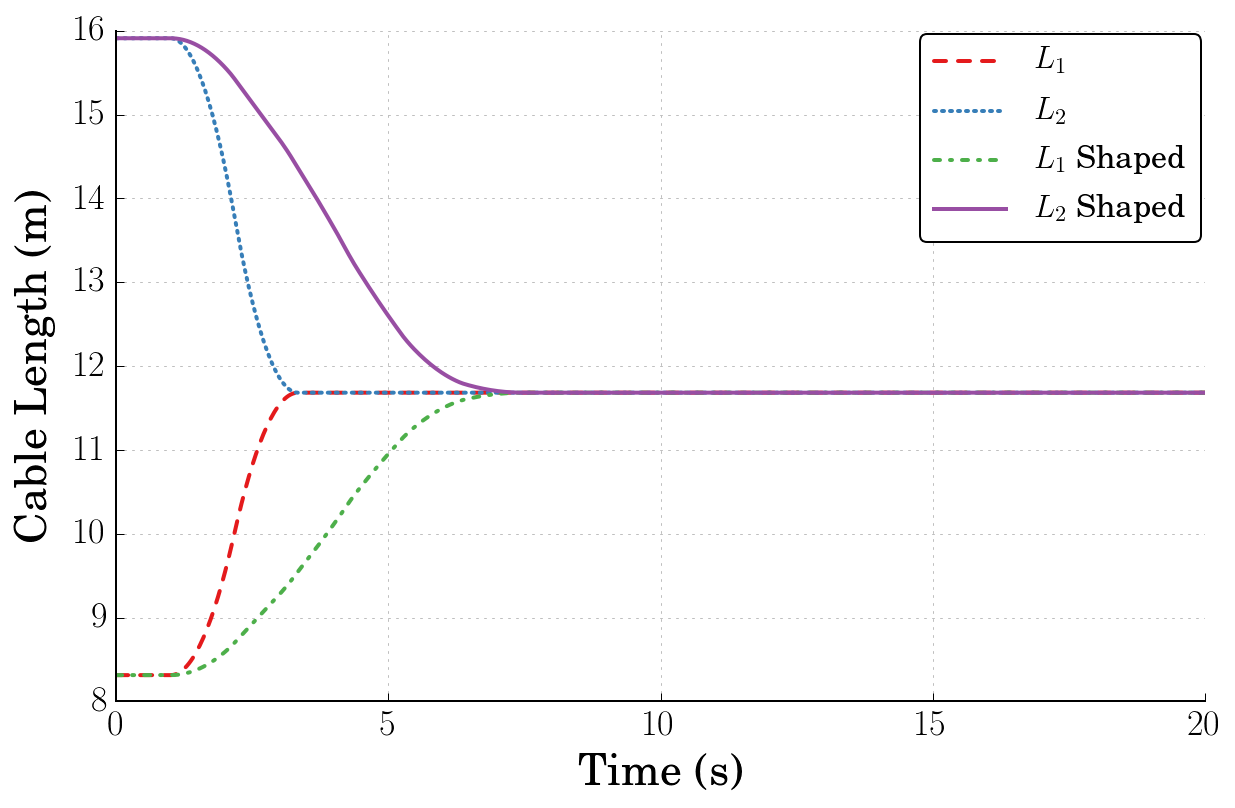

In [75]:
# Set the plot size - 3x2 aspect ratio is best
time = np.linspace(0,20,20*30)
fig = plt.figure(figsize=(6,4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17,left=0.17,top=0.96,right=0.96)

# Change the axis units to CMU Serif
plt.setp(ax.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='serif',fontsize=18)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)',family='serif',fontsize=22,weight='bold',labelpad=5)
plt.ylabel('Cable Length (m)',family='serif',fontsize=22,weight='bold',labelpad=10)

plt.plot(time,s_curve(time,8.31242885404,11.6825,2.34,1),
         linewidth=2, linestyle="--", label=r'$L_1$')
plt.plot(time,s_curve(time,15.911357989,11.6825,2.34,1),
                      linewidth=2,linestyle=":", label=r'$L_2$')

plt.plot(time,shaping.shaped_input(s_curve,time,Shaper,8.31242885404,11.6825,2.34,1),
         linewidth=2, linestyle="-.", label=r'$L_1$ Shaped')
plt.plot(time,shaping.shaped_input(s_curve, time,Shaper,15.911357989,11.6825,2.34,1),
                      linewidth=2, label=r'$L_2$ Shaped')

# uncomment below and set limits if needed
# xlim(0,5)
# ylim(0,10)
# Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext,family='serif',fontsize=16)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# save the figure as a high-res pdf in the current folder
plt.savefig('/Users/forrest/Desktop/rod_length_change_shaped.pdf',dpi=600)

fig.set_size_inches(9,6) # Resize the figure for better display in the notebook